In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve


In [2]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Verify that the drive is mounted
!ls /content/drive/MyDrive/datamining_assignment3

Titanic-Dataset-1.csv


In [4]:
file_path = '/content/drive/MyDrive/datamining_assignment3/Titanic-Dataset-1.csv'
df = pd.read_csv(file_path)

In [58]:
# --- 1. Data Cleaning ---
print("Initial missing values:\n", df.isnull().sum())

# Handle target variable first
df = df[~df['Survived'].isna()]  # Remove rows with missing survival data
df['Survived'] = df['Survived'].astype(int)

# Drop columns with >90% missing values
high_missing_cols = [col for col in df.columns if df[col].isnull().mean() > 0.9]
df.drop(columns=high_missing_cols, inplace=True, errors='ignore')
print(f"\nDropped columns with >90% missing values: {high_missing_cols}")

# Handle remaining missing values
imputer_median = SimpleImputer(strategy='median')
imputer_mode = SimpleImputer(strategy='most_frequent')

df['Age'] = imputer_median.fit_transform(df[['Age']])
df['Fare'] = imputer_median.fit_transform(df[['Fare']])
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Drop irrelevant features if present
drop_cols = ['PassengerId', 'Ticket', 'Name']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True, errors='ignore')

Initial missing values:
 Survived        0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           7
Fare            0
Cabin         687
Embarked        0
FamilySize      7
IsAlone         0
dtype: int64

Dropped columns with >90% missing values: []


<ipython-input-58-b6a502155f49>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)


In [59]:
# --- 2. Feature Engineering ---
df['FamilySize'] = df.get('SibSp', 0) + df.get('Parch', 0) + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

print("\nFinal missing values:\n", df.isnull().sum())



Final missing values:
 Survived        0
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           7
Fare            0
Cabin         687
Embarked        0
FamilySize      7
IsAlone         0
dtype: int64


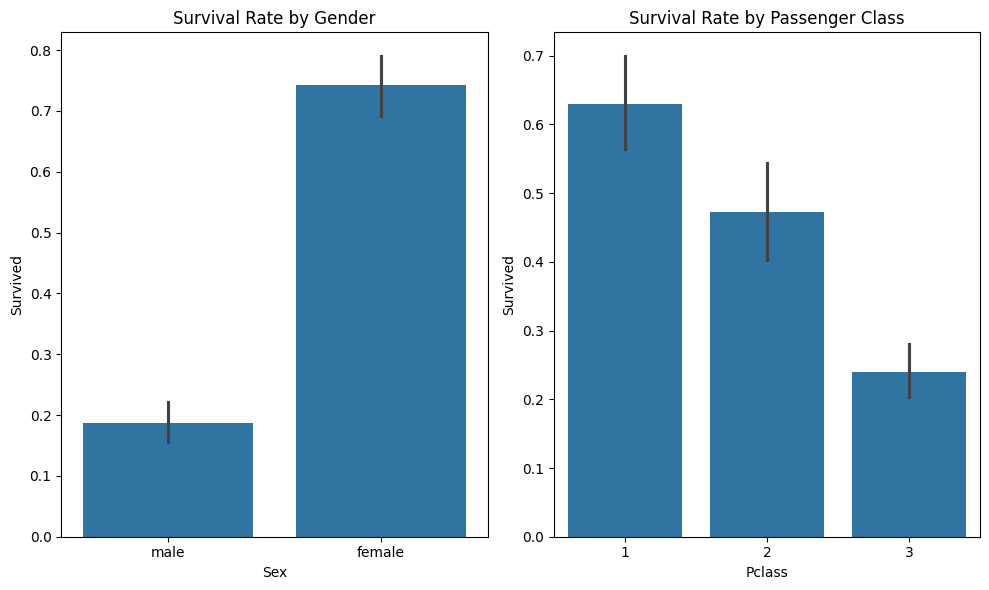

In [60]:
# --- 3. Exploratory Data Analysis (EDA) ---
plt.figure(figsize=(10, 6))

# Gender vs Survival
plt.subplot(1, 2, 1)
sns.barplot(x='Sex', y='Survived', data=df)
plt.title("Survival Rate by Gender")

# Class vs Survival
plt.subplot(1, 2, 2)
sns.barplot(x='Pclass', y='Survived', data=df)
plt.title("Survival Rate by Passenger Class")
plt.tight_layout()
plt.show()

In [61]:
# --- 4. Data Preprocessing ---
# Define categorical and numerical features
categorical_features = ['Sex', 'Embarked']
numerical_features = ['Age', 'Fare', 'Pclass', 'SibSp', 'Parch', 'FamilySize', 'IsAlone']

# Create preprocessing pipelines
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipe, numerical_features),
    ('cat', categorical_pipe, categorical_features)
])


In [62]:
# --- 5. Model Development ---
X = df.drop('Survived', axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
log_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Decision Tree
dt_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# PCA + Random Forest
pca_rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Hyperparameter tuning for Decision Tree
param_grid_dt = {
    'classifier__max_depth': [3, 5, None],
    'classifier__min_samples_split': [2, 5]
}

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'classifier__max_depth': [3, 5, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__n_estimators': [100, 200]  # Example: Add number of estimators
}

dt_search = GridSearchCV(dt_pipe, param_grid_dt, cv=5, scoring='accuracy')
rf_search = GridSearchCV(pca_rf_pipe, param_grid_rf, cv=5, scoring='accuracy')

In [63]:
# Train models
log_pipe.fit(X_train, y_train)
dt_search.fit(X_train, y_train)
rf_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare',
                                                                          'Pclass',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'FamilySize',
                                                                          'IsAlone']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Sex',
                                                                          'Embarked'])])),
                                       ('pca', PCA(n_components=5)),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [3, 5, None],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='accuracy')

In [64]:
# --- 6. Model Evaluation ---
def evaluate_model(model, X, y, model_name="Model"):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_proba)
    cm = confusion_matrix(y, y_pred)
    report = classification_report(y, y_pred)

    print(f"=== {model_name} ===")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")

    print("\nConfusion Matrix:")
    cm_df = pd.DataFrame(cm, columns=['Predicted Not Survived', 'Predicted Survived'],
                         index=['Actual Not Survived', 'Actual Survived'])
    print(cm_df)

    print("\nClassification Report:")
    print(report)
    print("-" * 40)  # Separator for clarity

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y, y_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

=== Logistic Regression ===
Accuracy: 0.82
ROC AUC: 0.83

Confusion Matrix:
                     Predicted Not Survived  Predicted Survived
Actual Not Survived                     102                  19
Actual Survived                          13                  45

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.86       121
           1       0.70      0.78      0.74        58

    accuracy                           0.82       179
   macro avg       0.80      0.81      0.80       179
weighted avg       0.83      0.82      0.82       179

----------------------------------------
=== Optimized Decision Tree ===
Accuracy: 0.82
ROC AUC: 0.85

Confusion Matrix:
                     Predicted Not Survived  Predicted Survived
Actual Not Survived                     104                  17
Actual Survived                          16                  42

Classification Report:
              precision    recall  f1-score 

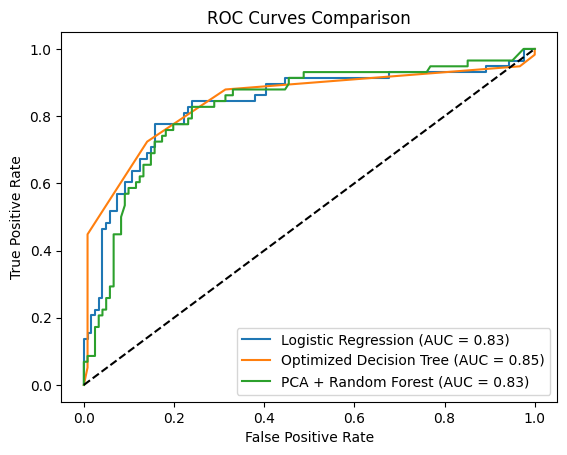

In [65]:
# Evaluate models
evaluate_model(log_pipe, X_test, y_test, model_name="Logistic Regression")
evaluate_model(dt_search.best_estimator_, X_test, y_test, model_name="Optimized Decision Tree")
evaluate_model(rf_search.best_estimator_, X_test, y_test, model_name="PCA + Random Forest")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()


In [66]:
# --- 7. Business Recommendations ---
print("\nKey Insights:")
print("1. Females had 74% survival rate vs 19% for males")
print("2. 1st Class passengers had 63% survival rate vs 24% for 3rd Class")

print("\nRecommendations:")
print("- Prioritize safety protocols for male passengers in lower classes")
print("- Improve evacuation procedures for lower deck accommodations")


Key Insights:
1. Females had 74% survival rate vs 19% for males
2. 1st Class passengers had 63% survival rate vs 24% for 3rd Class

Recommendations:
- Prioritize safety protocols for male passengers in lower classes
- Improve evacuation procedures for lower deck accommodations


In [71]:
# Persona Example
print("\nPersona: Thomas O'Connor (Male, 28, 3rd Class)")
# Create a DataFrame with the persona's data (ensure it matches your feature names)
persona_data = pd.DataFrame({
    'Sex': ['male'],
    'Age': [28],
    'Pclass': [3],
    'SibSp': [0],
    'Parch': [0],
    'Fare': [20],
    'Embarked': ['S'],
    'FamilySize': [1],
    'IsAlone': [1]
})

# Make a prediction using the Logistic Regression model
try:
    survival_probability = log_pipe.predict_proba(persona_data)[:, 1][0]
    print(f"Survival Probability Prediction: {survival_probability * 100:.2f}%")
    print("Risk Factors: Male gender, lower class ticket, traveling alone")
except ValueError as e:
    print(f"ValueError: {e}")
    print("Check that the features in persona_data match the columns used during training.")


Persona: Thomas O'Connor (Male, 28, 3rd Class)
Survival Probability Prediction: 10.22%
Risk Factors: Male gender, lower class ticket, traveling alone
